### 計算圖(computational graph)
#### 優點
* 利用局部性的計算，讓目標的節點專注於單純的計算，將複雜的問題簡單化
* 可以維持所有計算過程中的結果
* 透過誤差反向傳播法，可以有效計算微分

#### 反向傳播
* 加法節點運算: 直接將反向傳播的輸入訊號(微分值)輸出給下一個節點
* 乘法節點運算: 反向傳播的輸入訊號(微分值)須乘上正向傳播輸入訊號的相反值

#### 加法層(AddLayer)

In [1]:
# 定義加法層類別
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        
        return dx, dy

#### 乘法層(MulLayer)

In [2]:
# 定義乘法層類別
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy

#### 活化函數 - ReLU 層
* ReLU (Rectified Linear Unit) function:
$$y=\left\{\begin{matrix}
x&(x>0)\\ 
0& (x\leq 0)
\end{matrix}\right.$$

* Differentiation:
$$\frac{\mathrm{d} y}{\mathrm{d} x}=\left\{\begin{matrix}
1&(x>0)\\ 
0& (x\leq 0)
\end{matrix}\right.
$$

In [3]:
# 定義 ReLU 層類別
class Relu_Layer:
    def __init__(self):
        # 實例變數 mask 為 True/False 形成的 Numpy array
        self.mask = None
    
    def forward(self, x):
        # x 小於或等於零為 True, 大於零為 False
        self.mask = (x <= 0)
        out = x.copy()
        # 將 mask 元素為 True 的位置設定成零 (x <= 0 的值變為零)
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

#### 活化函數 - Sigmoid 層
* Sigmoid function:
$$ y=\frac{1}{1+e^{-x}} $$

* Differentiation:
$$ \frac{\mathrm{d} y}{\mathrm{d} x}=y^{2}e^{-x}=y(1-y) $$

In [4]:
# 定義 Sigmoid 層類別
class Sigmoid_Layer:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        
        return dx

#### Affine 層 (執行矩陣運算)
* Matrix calculation:
$$ \mathbf{Y} = \mathbf{X}\cdot\mathbf{W}+\mathbf{B} $$


* Differentiation:
$$
\begin{align*}
\frac{\partial L}{\partial \mathbf{X}} &= \frac{\partial L}{\partial \mathbf{Y}}\cdot\mathbf{W}^{T} \\\\ 
\frac{\partial L}{\partial \mathbf{W}} &= \mathbf{X}^{T}\cdot\frac{\partial L}{\partial \mathbf{Y}}\end{align*} 
$$

#### 批次處理的 Affine 層

In [5]:
# 定義批次處理的 Affine 層
class Affine_Layer:
    def __init__(self, W, b):
        self.X = None
        self.W = W
        self.b = b
        self.dW = None
        self.db = None
        
    def forward(self, X):
        self.X = X
        out = np.dot(X, self.W) + self.b
        
        return out 
    
    def backward(self, dout):
        dX = np.dot(dout, self.W.T)
        self.dW = np.dot(self.X.T, dout)
        # 偏權值的反向傳播: 假設資料有 N 組，統計這 N 組資料相同維度的微分
        # axis = 0: 針對第零軸(以資料為單位的軸)做元素值的加總
        self.db = np.sum(dout, axis = 0)
        
        return dX

#### 輸出層的活化函數: Softmax-with-loss 層 (softmax function with cross entropy error)
* Softmax function:
$$ y_{k}=\frac{e^{x_{k}}}{\sum_{i=1}^{n}e^{x_{i}}} $$


* Cross entropy error:
$$ L=-\sum_{k}t_{k}\cdot log(y_{k}) $$


* Differentiation:
$$ \frac{\partial L}{\partial x_{k}} = y_{k}-t_{k} $$

In [6]:
def softmax(x):
    # c 的目的為防範溢位
    c = np.max(x)
    exp_x = np.exp(x - c)
    sum_exp_x = np.sum(exp_x)
    y = exp_x / sum_exp_x
        
    return y    

# 小批次處理的交叉熵誤差(cross entropy error)- t 使用 one-hot-label    
def batch_cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 找出每一組 t 資料中正確標籤的 index
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    
    # 將每一組 y 資料的值列出(對應於 t 資料的正確標籤 index)，取 log 再加總
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
    
# 定義 Softmax-with-loss 層
class Softmax_With_Loss_Layer:
    def __init__(self):
        self.loss = None 
        self.y = None    
        self.t = None    # 訓練資料 (one-hot vector)
    
    def forward(self, x, t):
        self.y = softmax(x)
        self.t = t
        self.loss = batch_cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

### 誤差反向傳播法

#### 建立誤差反向傳播法的雙層神經網路

In [7]:
import numpy as np
# 引入有序字典 OrderedDict，可以記住新增至字典內的元素順序
from collections import OrderedDict

'''
#定義數值梯度
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    # np.nditer: numpy array 自帶的迭代器
    # flags=['multi_index']: 表示對 a 進行多重索引
    # op_flags=['readwrite']: 表示不僅對 a 進行 read（讀取），還可以 write（寫入)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        # it.multi_index: 表示元素的索引，可以看到結果都是 index
        idx = it.multi_index
        tmp_val = x[idx]
        
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        x[idx] = float(tmp_val) - h 
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
                
        x[idx] = tmp_val
        # it.iternext(): 表示進入下一次迭代
        it.iternext()   
   
    return grad
'''

#定義雙層網路的類別
class two_layer_net:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        
        # 建立 two_layer_net 類別的實例變數: self.params、self.layers、self.lastLayer
        
        #初始化雙層神經網路中的權重與偏權值之函數
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # 產生隱藏層各層
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine_Layer(self.params['W1'], self.params['b1'])
        self.layers['Sigmoid1'] = Sigmoid_Layer()
        self.layers['Affine2'] = Affine_Layer(self.params['W2'], self.params['b2'])
        
        #產生輸出層
        self.lastLayer = Softmax_With_Loss_Layer()
        
    #定義雙層神經網路向前傳播的過程
    def forward_predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
    
        return x

    #定義損失函數
    def loss(self, x, t):
        y = self.forward_predict(x)
        
        return self.lastLayer.forward(y, t)
    
    #定義梯度
    def gradient(self, x, t):
        #forward
        self.loss(x, t)
        
        #backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        for layer in reversed(self.layers.values()):
            dout = layer.backward(dout)
        
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads
    
    '''
    #定義數值梯度
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads
    '''
    
    #計算準確度
    def accuracy(self, x, t):
        y = self.forward_predict(x)
        y = np.argmax(y, axis = 1)
        t = np.argmax(t, axis = 1)
        
        accuracy= np.sum(y == t) / float(x.shape[0])
        
        return accuracy

#### 誤差反向傳播法的梯度檢查(gradient check)

In [ ]:
import numpy as np
from dataset.mnist import load_mnist

#取得資料
(x_train, t_train), (x_test, t_test) = \
    load_mnist(flatten = True, normalize = True, one_hot_label = True)

#設定神經網路
network = two_layer_net(input_size = 784, hidden_size = 50, output_size = 10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backpropagation = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backpropagation[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

#### 誤差反向傳播法的神經網路學習

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from ProcessBar.Process_Bar import *

#取得資料
(x_train, t_train), (x_test, t_test) = \
    load_mnist(flatten = True, normalize = True, one_hot_label = True)

#設定神經網路
network = two_layer_net(input_size = 784, hidden_size = 50, output_size = 10)

#設定超參數
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
lr = 0.1

#建立訓練過程中的損失函數值列表
train_loss_list = []

#建立訓練與測試資料的辯識準確度列表
train_acc_list = []
test_acc_list = []

# 每一週期的重複次數
iter_per_epoch = max(train_size/batch_size, 1)

#建立進度條
process_bar = ShowProcess(iters_num, '計算完成')

#執行小批次學習
for i in range(iters_num):
    #取得小批次
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    #利用誤差反向傳播法計算梯度
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    #更新參數
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= lr * grad[key]
        
    #紀錄學習過程
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    #計算一個周期的辯識準確度
    if i % iter_per_epoch == 0 and i != 0 :
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("(train acc, test acc) = " + "(" + str(train_acc) + "," + str(test_acc) + ")")
    
    #顯示當前進度
    process_bar.show_process()
    time.sleep(0.01)

(train acc, test acc) = (0.793083333333,0.7976)----]6.00%
(train acc, test acc) = (0.879433333333,0.8848)----]12.00%
(train acc, test acc) = (0.898916666667,0.9016)----]18.00%
(train acc, test acc) = (0.9076,0.91)--------------]24.00%
(train acc, test acc) = (0.9141,0.9175)------------]30.00%
(train acc, test acc) = (0.919883333333,0.9224)----]36.00%
(train acc, test acc) = (0.92465,0.9253)-----------]42.00%
(train acc, test acc) = (0.92865,0.9299)-----------]48.00%
(train acc, test acc) = (0.931566666667,0.9335)----]54.00%
(train acc, test acc) = (0.934216666667,0.9351)----]60.00%
(train acc, test acc) = (0.93725,0.9373)-----------]66.00%
(train acc, test acc) = (0.93975,0.9389)-----------]72.00%
(train acc, test acc) = (0.941233333333,0.9412)----]78.00%
(train acc, test acc) = (0.943683333333,0.9427)----]84.00%
(train acc, test acc) = (0.94495,0.9437)∎∎∎∎∎∎-----]90.00%
(train acc, test acc) = (0.9465,0.945)∎∎∎∎∎∎∎∎∎∎∎--]96.00%
[∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎]100.0

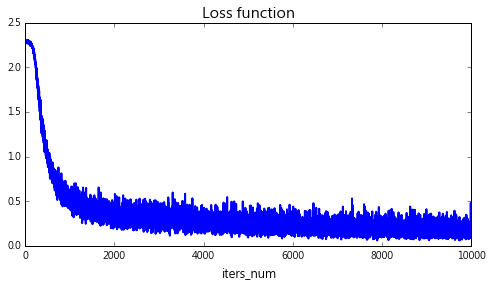

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.arange(iters_num), train_loss_list, color='b', lw=2)
ax.set_ylim(0, 2.5)
ax.set_title("Loss function", fontsize = 15)
ax.set_xlabel("iters_num", fontsize = 12)

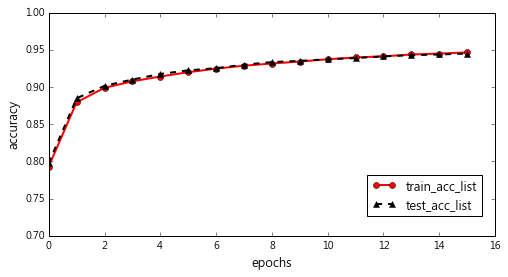

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.arange(int(iters_num/iter_per_epoch)), train_acc_list, color='r', linestyle="-", marker="o", lw=2, label="train_acc_list")
ax.plot(np.arange(int(iters_num/iter_per_epoch)), test_acc_list, color='k', linestyle="--", marker="^", lw=2, label="test_acc_list")
ax.set_ylim(0.7, 1)
ax.set_xlabel("epochs", fontsize = 12)
ax.set_ylabel("accuracy", fontsize = 12)
plt.legend(loc='upper left', bbox_to_anchor=(0.7, 0.3))